In [ ]:
from fastai2.vision.all import *
from siren import Siren, apply_siren_init, siren_init

# Loading data

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [4]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [32]:
block = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter(valid_name='val'),
                   item_tfms = Resize(128), 
                   batch_tfms= Normalize.from_stats(*imagenet_stats))

In [33]:
data = block.dataloaders(path)

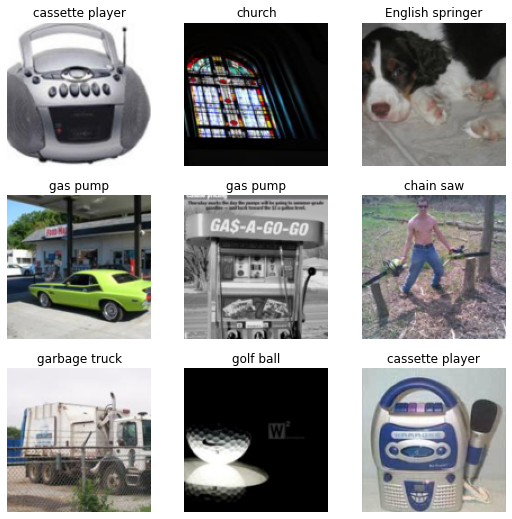

In [7]:
data.show_batch()

# Experiment with normal xresnet model (from fastai)

epoch,train_loss,valid_loss,accuracy,time
0,1.336876,2.040840,0.440255,00:13
1,1.000372,0.916238,0.718217,00:13
2,0.818345,0.905245,0.719236,00:14
3,0.685584,0.753442,0.756943,00:14
4,0.617587,0.824612,0.734777,00:14
5,0.521455,0.684876,0.786497,00:14
6,0.471018,0.681329,0.789809,00:14
7,0.390397,0.683945,0.794904,00:14
8,0.337095,1.047019,0.728408,00:14
9,0.318871,0.644297,0.816815,00:14


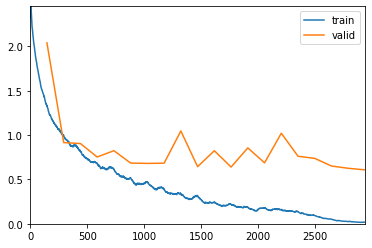

In [118]:
learn = Learner(data, xresnet18(n_out=10), metrics=accuracy, opt_func=ranger, cbs=ShowGraphCallback)
# learn.lr_find()
learn.fit_flat_cos(20, 3e-3)

Trying to close the gap between validation loss and training loss using data augmentation

epoch,train_loss,valid_loss,accuracy,time
0,1.420916,1.493526,0.537834,00:15
1,1.075228,1.009249,0.683567,00:15
2,0.927014,0.952767,0.701656,00:15
3,0.795350,0.824762,0.744459,00:15
4,0.729560,0.876980,0.725096,00:15
5,0.651999,0.640907,0.795669,00:15
6,0.614747,0.906498,0.713885,00:15
7,0.586123,0.679996,0.778599,00:15
8,0.540323,0.675258,0.797452,00:15
9,0.504925,0.612417,0.802803,00:15


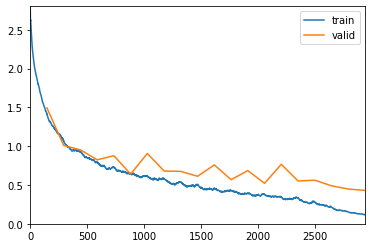

In [122]:
data_with_aug = block.new(item_tfms = Resize(128),
          batch_tfms=[*aug_transforms(size=128), Normalize.from_stats(*imagenet_stats)]
               ).dataloaders(path)
learn = Learner(data_with_aug, xresnet18(n_out=10), metrics=accuracy, opt_func=ranger, cbs=ShowGraphCallback)
# learn.lr_find()
learn.fit_flat_cos(20, 3e-3)

# Now trying siren activation instead of ReLu

https://forums.fast.ai/t/normalizing-images-with-a-lambda-instead-of-stats-latest-efficientnet-requiires-it/62441/8

In [39]:
class NormalizeEf(Transform):
    "AdvProp Normalization for `TensorImage`"
    order=99
    def encodes(self, x:TensorImage): return (x * 2.) - 1.
    def decodes(self, x:TensorImage): return (x + 1.) / 2.

In [40]:
data_siren = block.new(item_tfms = Resize(128),
                      batch_tfms=NormalizeEf).dataloaders(path)

In [98]:
def init_cnn_siren(m):
    if isinstance(m, (nn.Conv2d,nn.Linear)): 
        apply_siren_init(m)
    for l in m.children():
        init_cnn_siren(l)

In [ ]:
def get_siren_resnet():
    mdl = xresnet18(n_out=10, act_cls=Siren)
    init_cnn_siren(mdl)
    return mdl

epoch,train_loss,valid_loss,accuracy,time
0,1.744400,2.194060,0.331975,00:15
1,1.318278,1.142223,0.631338,00:15
2,1.082296,1.351219,0.564331,00:15
3,0.907958,0.846890,0.730446,00:15
4,0.814928,1.038293,0.685350,00:15
5,0.688228,0.836880,0.741911,00:15
6,0.598763,1.265460,0.619363,00:15
7,0.520419,0.805111,0.758981,00:15
8,0.434523,0.983355,0.718981,00:15
9,0.356696,0.838144,0.765096,00:15


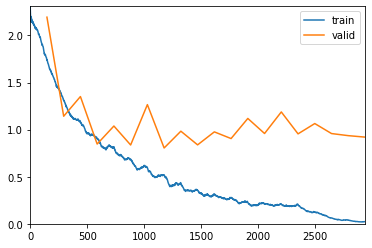

In [108]:
mdl = get_siren_resnet()
siren_learn = Learner(data_siren, mdl, metrics=accuracy, opt_func=ranger, cbs=ShowGraphCallback)
# siren_learn.lr_find()
siren_learn.fit_flat_cos(20, 3e-2)

The model is overfitting, so I tried to apply regularization in the form of data augmentation

epoch,train_loss,valid_loss,accuracy,time
0,1.758127,1.929113,0.398726,00:16
1,1.371261,1.177028,0.614013,00:16
2,1.158285,1.847262,0.448917,00:16
3,1.015653,0.954545,0.696815,00:16
4,0.888962,1.048555,0.661911,00:16
5,0.831067,0.775846,0.761529,00:16
6,0.777445,0.984709,0.679745,00:18
7,0.690723,0.772630,0.756943,00:16
8,0.624103,1.048862,0.683057,00:16
9,0.609870,0.680361,0.789809,00:17


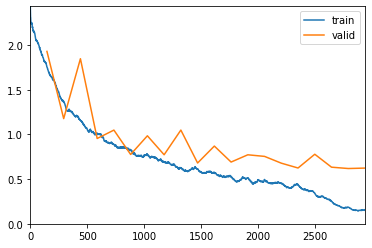

In [110]:
dls = block.new(item_tfms = Resize(128),
          batch_tfms=[*aug_transforms(size=128), NormalizeEf]
               ).dataloaders(path)
mdl = get_siren_resnet()
siren_learn = Learner(dls, mdl, metrics=accuracy, opt_func=ranger, cbs=ShowGraphCallback)
# siren_learn.lr_find()
siren_learn.fit_flat_cos(20, 3e-2)

More regularization, this time weight decay is added

epoch,train_loss,valid_loss,accuracy,time
0,1.848822,1.785700,0.411975,00:16
1,1.440074,1.255015,0.588535,00:16
2,1.139328,1.057039,0.662930,00:16
3,1.011043,0.896064,0.715669,00:16
4,0.879917,0.923713,0.707771,00:16
5,0.816185,0.778542,0.756688,00:16
6,0.720457,0.941793,0.702166,00:18
7,0.697603,0.693498,0.775796,00:17
8,0.642775,0.958871,0.721783,00:16
9,0.601802,0.651761,0.798217,00:16


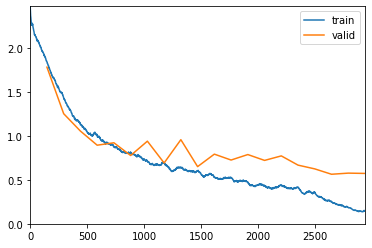

In [115]:
dls = block.new(item_tfms = Resize(128),
          batch_tfms=[*aug_transforms(size=128), NormalizeEf]
               ).dataloaders(path)
mdl = get_siren_resnet()
siren_learn = Learner(dls, mdl, wd=1e-3, metrics=accuracy, opt_func=ranger, cbs=ShowGraphCallback)
# siren_learn.lr_find()
siren_learn.fit_flat_cos(20, 3e-2)

Still not as good as the ReLu xresnet (87.4% accuracy vs 83.8%), training for the same number of epochs